In [3]:
import CTApy
import pandas as pd
import numpy as np
import random
import os

import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import fasttext
import torch
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

In [1]:
import spacy

# Load the spacy model
nlp = spacy.load('en_core_web_sm')

# Print the version
print(nlp.meta['version'])


3.7.1


In [4]:
# Set a seed value
seed_value = 42  # can be any number

os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

In [5]:
# load data
path_data=""
df = pd.read_csv(path_data+"cta_data/gadarian_lemmatized.csv",sep=",",dtype=str)


path_graphs=""

In [6]:
# Prepare data for the fasttext model
data_words = df['text_lemma'].str.split().tolist()

In [16]:
# Load pre-trained model
pretrained_model = fasttext.load_facebook_model("research_data/cc.en.300.bin")

# Update the model with new data
pretrained_model.build_vocab(corpus_iterable=data_words, update=True)
pretrained_model.train(corpus_iterable=data_words, total_examples=len(data_words), epochs=pretrained_model.epochs)

(1049, 4698)

In [17]:
# The seed value
seed_value = 42

# Set the seed for Python's random module
random.seed(seed_value)

# Set the seed for NumPy's random number generator
np.random.seed(seed_value)

# Set the seed for PyTorch's random number generator
# Uncomment the line below if you're using PyTorch
torch.manual_seed(seed_value)




In [18]:
sentence_model = SentenceTransformer("all-mpnet-base-v2")

In [19]:
# Create a UMAP model with the seed value
# umap_model = UMAP(random_state=seed_value)
umap_model = UMAP(random_state=42)

# Fine-tune your topic representations
representation_model = KeyBERTInspired()
# topic_model = BERTopic(umap_model=umap_model,representation_model=representation_model,embedding_model=sentence_model)
topic_model = BERTopic(umap_model=umap_model,representation_model=representation_model)

In [20]:
text_lemma=df['text_lemma']
outcome=df['outcome']

[['immigrant', 'immigration', 'mexican', 'deport', 'immigrate'], ['taxis', 'pay', 'tax', 'government', 'immigrant'], ['job', 'work', 'loss', 'pay', 'come'], ['illegal', 'legal', 'free', 'bad', 'not']]
Average compound score for sublist 1: 0.0
Average compound score for sublist 2: -0.02054
Average compound score for sublist 3: -0.08418
Average compound score for sublist 4: -0.09222


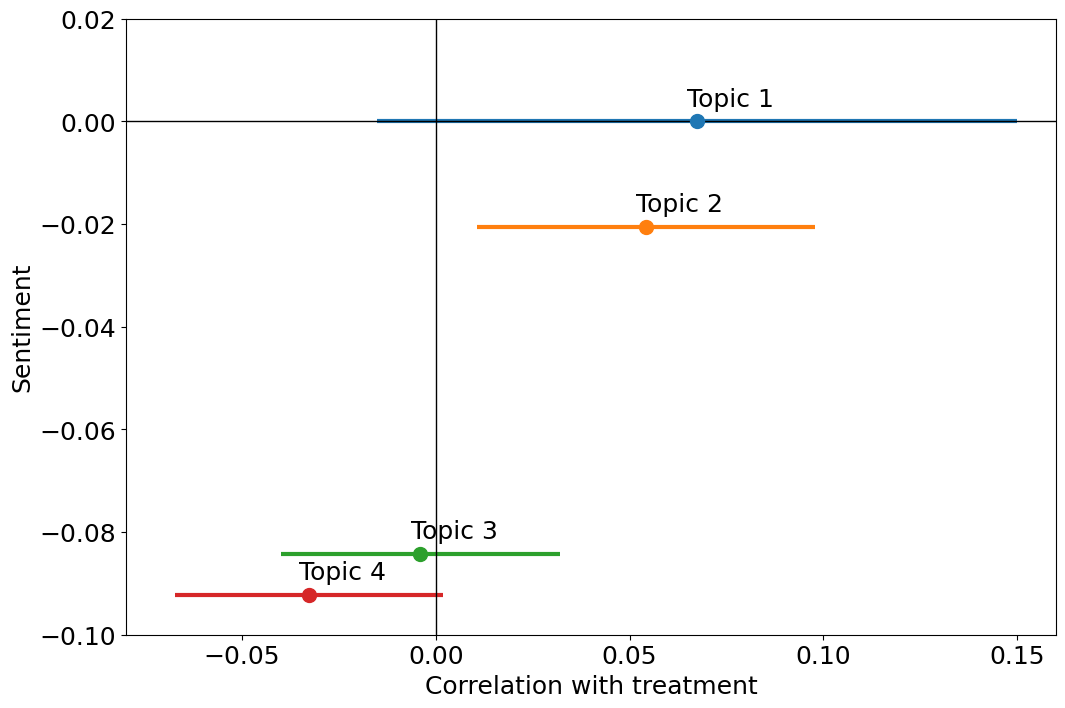

In [21]:
analyzer = SentimentIntensityAnalyzer()
# Get the topics for each document
topics, _ = topic_model.fit_transform(text_lemma)

# Get unique topics
unique_topics = np.unique(topics)

df_bert = pd.DataFrame({'topic':topics,'outcome':outcome})
# Convert "topic" into dummy variables and prefix the column names with "topic_"
df_dummies = pd.get_dummies(df_bert['topic'], prefix='topic')*1

# Check if 'topic_-1' is in the DataFrame
if 'topic_-1' in df_dummies.columns:
    # Remove 'topic_-1' column
    df_dummies = df_dummies.drop(columns='topic_-1')

# Concatenate the outcome column with the new dummy columns
df_final = pd.concat([df['outcome'], df_dummies], axis=1)

# Convert DataFrame to numeric data type
df_final = df_final.apply(pd.to_numeric, errors='coerce')


# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []

# Run a linear regression for each topic dummy
for column in df_final.columns:
    if column != 'outcome':
        X = df_final['outcome']
        y = df_final[column]
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)


# Get the topics
topics = topic_model.get_topic_info()['Topic'].unique()

# Initialize an empty list to hold the top words for each topic
top_words_per_topic = []

# Loop over the topics
for topic in topics:
    if topic != -1:  # We skip -1 as it represents the 'unclassified' topic
        # Get the top 5 words for the topic
        top_words = [word for word, prob in topic_model.get_topic(topic)[:5]]
        # Add the top words to our list
        top_words_per_topic.append(top_words)
print(top_words_per_topic)        
# Initialize an empty list to hold the average compound scores
average_scores = []

# Loop over the sublists
for sublist in top_words_per_topic:
    # Initialize a variable to hold the sum of the compound scores
    compound_sum = 0
    # Loop over the words in the sublist
    for word in sublist:
        # Get the sentiment scores
        sentiment = analyzer.polarity_scores(word)
        # Add the compound score to the sum
        compound_sum += sentiment['compound']
    # Calculate the average compound score and add it to the list of average scores
    average_scores.append(compound_sum / len(sublist))

# Print the average compound scores
for i, score in enumerate(average_scores):
    print(f"Average compound score for sublist {i + 1}: {score}")
    
    
coeff_sentiment=pd.DataFrame({'topic':df_final.columns[df_final.columns != 'outcome'],
                              'coefficient':coefficients,'sentiment':average_scores, 'conf_intervals':conf_intervals})    
coeff_sentiment['topic']=['Topic 1','Topic 2','Topic 3','Topic 4'] 
# Create scatterplot

plt.figure(figsize=(12, 8))  # Increase plot size

# Add error bars
for i in range(coeff_sentiment.shape[0]):
    x = coeff_sentiment['coefficient'][i]
    y = coeff_sentiment['sentiment'][i]
    ci = coeff_sentiment['conf_intervals'][i]
    plt.errorbar(x, y, xerr=np.array([[x - ci[0]], [ci[1] - x]]), 
                 fmt='o', markersize=10, linewidth=3)  # Increase markersize and linewidth here

# Add labels
offset_y = 0.003 
offset_x = 0.0025 # Adjust this value to move the labels up or down
for i in range(coeff_sentiment.shape[0]):
    plt.text(coeff_sentiment['coefficient'][i] - offset_x, 
             coeff_sentiment['sentiment'][i] + offset_y, coeff_sentiment['topic'][i], fontsize=18)  # Increase font size here

plt.axhline(0, color='black',linewidth=1)  # Add y-axis line at 0
plt.axvline(0, color='black',linewidth=1)  # Add x-axis line at 0

# Define axis limits
plt.xlim([-0.08, 0.16])  # Set x-axis limits
plt.ylim([-0.1, 0.02])  # Set y-axis limits

plt.xlabel('Correlation with treatment', fontsize=18)  # Increase font size here
plt.ylabel('Sentiment', fontsize=18)  # Increase font size here
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.title('CTA: Scatterplot of Treatment Coefficients and Sentiment', fontsize=16)  # Increase font size here
# plt.grid(True)
plt.savefig(path_graphs+'bertopic_topic_treatment_gadarian.png',bbox_inches='tight')
plt.show()

In [22]:
print('Treatment=1')
print(coeff_sentiment[coeff_sentiment['coefficient']>0]['sentiment'].mean())
print('Treatment=0')
print(coeff_sentiment[coeff_sentiment['coefficient']<0]['sentiment'].mean())

Treatment=1
-0.01027
Treatment=0
-0.0882


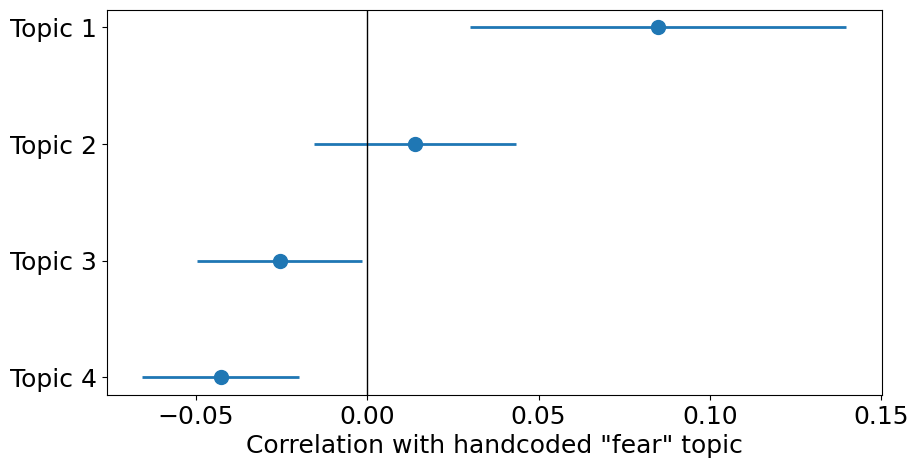

In [23]:
# Convert DataFrame to numeric data type
df_final = df_final.apply(pd.to_numeric, errors='coerce')
df_final.columns=['outcome','Topic 1','Topic 2','Topic 3','Topic 4']
outcome_toplot=pd.to_numeric(df['fear_ra1'])
# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []

# Run a linear regression for each topic dummy
for column in df_final.columns:
    if column != 'outcome':
        X = outcome_toplot
        y = df_final[column]
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)

# Plot coefficients with confidence intervals
# Define your desired font size and marker size
font_size = 18
marker_size = 10
line_width = 2

# Plot coefficients with confidence intervals
plt.figure(figsize=(10, 5))
topic_order=np.arange(len(coefficients),0,-1)-1
# Plot error bars with increased marker size and line width
plt.errorbar(coefficients, topic_order, 
             xerr=[abs((top-bot)/2) for top, bot in conf_intervals],
             fmt='o', markersize=marker_size, elinewidth=line_width)

plt.yticks(topic_order, df_final.columns[df_final.columns != 'outcome'], fontsize=font_size)
# Increase font size for x-axis labels
# Increase font size for x-axis labels
plt.xticks(fontsize=font_size)
plt.xlabel('Correlation with handcoded "fear" topic', fontsize=18)  # Increase font size here
plt.axvline(0, color='black',linewidth=1)

plt.savefig(path_graphs+'bertopic_topic_treatment_RA1_fear_gadarian.png',bbox_inches='tight')
plt.show()

In [24]:
# Flatten the list of lists into a single list
all_words_bertopic_top5 = [word for sublist in top_words_per_topic for word in sublist]

# Remove duplicates by converting the list to a set
unique_words = set(all_words_bertopic_top5)

# If you need a list, convert the set back to a list
all_words_bertopic_top5 = list(unique_words)



In [25]:
# cosine_matrix_bertopic=create_cosine_matrix(pretrained_model, all_words_bertopic_top5)
cosine_matrix_bertopic=CTApy.create_cosine_matrix(pretrained_model, all_words_bertopic_top5)


In [26]:
# overall quality (all 4 topics)
CTApy.calculate_quality_all(top_words_per_topic, cosine_matrix_bertopic)

0.24295845952500408

In [27]:
# BTM

In [28]:
btm_gadarian_topic_probabilities=pd.read_csv(
    path_data+"btm_gadarian_topic_probabilities.csv"
,sep=",",dtype=str)

btm_words=pd.read_csv(path_data+"btm_gadarian_top_words.csv",
                      sep=",",dtype=str)

btm_gadarian_topic_probabilities['treatment']=outcome
btm_gadarian_topic_probabilities=btm_gadarian_topic_probabilities.drop(columns='doc')

top_words_per_topic_btm = [words[0] for words in [btm_words[col].str.split(', ').tolist() for col in btm_words.columns]]

Average compound score for sublist 1: -0.11148
Average compound score for sublist 2: -0.13202
Average compound score for sublist 3: -0.08808
Average compound score for sublist 4: -0.02054


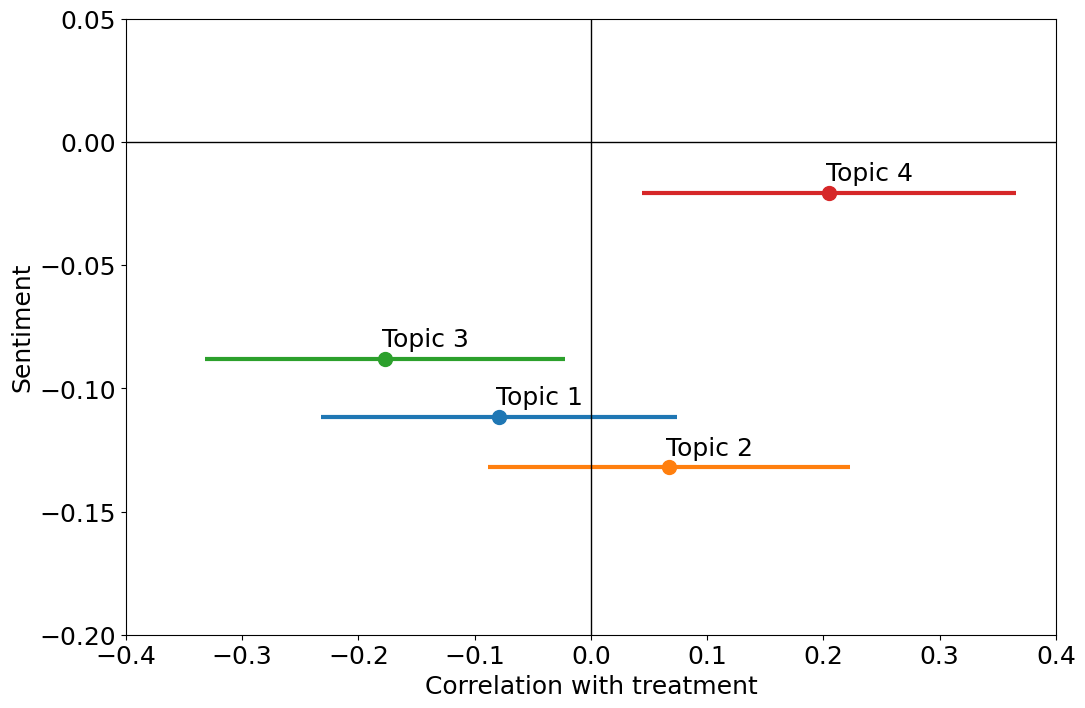

In [29]:
# Initialize an empty list to hold the average compound scores
average_scores = []

# Loop over the sublists
for sublist in top_words_per_topic_btm:
    # Initialize a variable to hold the sum of the compound scores
    compound_sum = 0
    # Loop over the words in the sublist
    for word in sublist:
        # Get the sentiment scores
        sentiment = analyzer.polarity_scores(word)
        # Add the compound score to the sum
        compound_sum += sentiment['compound']
    # Calculate the average compound score and add it to the list of average scores
    average_scores.append(compound_sum / len(sublist))

# Print the average compound scores
for i, score in enumerate(average_scores):
    print(f"Average compound score for sublist {i + 1}: {score}")

# Convert DataFrame to numeric data type
# topics_lda = topics_lda.apply(pd.to_numeric, errors='coerce')

# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []
btm_gadarian_topic_probabilities = btm_gadarian_topic_probabilities.apply(pd.to_numeric, errors='coerce')
# Run a linear regression for each topic dummy
for column in btm_gadarian_topic_probabilities.columns:
    if column != 'treatment':
        X = btm_gadarian_topic_probabilities[column]
        y = btm_gadarian_topic_probabilities['treatment']
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)

coeff_sentiment=pd.DataFrame({'topic':btm_gadarian_topic_probabilities.columns[btm_gadarian_topic_probabilities.columns != 'treatment'],
                              'coefficient':coefficients,'sentiment':average_scores, 'conf_intervals':conf_intervals})   
# Create scatterplot

plt.figure(figsize=(12, 8))  # Increase plot size

# Add error bars
for i in range(coeff_sentiment.shape[0]):
    x = coeff_sentiment['coefficient'][i]
    y = coeff_sentiment['sentiment'][i]
    ci = coeff_sentiment['conf_intervals'][i]
    plt.errorbar(x, y, xerr=np.array([[x - ci[0]], [ci[1] - x]]), 
                 fmt='o', markersize=10, linewidth=3)  # Increase markersize and linewidth here

coeff_sentiment['topic']=['Topic 1','Topic 2','Topic 3','Topic 4'] 

# Add labels
offset_y = 0.005 
offset_x = 0.0025 # Adjust this value to move the labels up or down
for i in range(coeff_sentiment.shape[0]):
    plt.text(coeff_sentiment['coefficient'][i] - offset_x, 
             coeff_sentiment['sentiment'][i] + offset_y, coeff_sentiment['topic'][i], fontsize=18)  # Increase font size here

plt.axhline(0, color='black',linewidth=1)  # Add y-axis line at 0
plt.axvline(0, color='black',linewidth=1)  # Add x-axis line at 0

# Define axis limits
plt.xlim([-0.4, 0.4])  # Set x-axis limits
plt.ylim([-0.2, 0.05])  # Set y-axis limits

plt.xlabel('Correlation with treatment', fontsize=18)  # Increase font size here
plt.ylabel('Sentiment', fontsize=18)  # Increase font size here
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.title('CTA: Scatterplot of Treatment Coefficients and Sentiment', fontsize=16)  # Increase font size here
# plt.grid(True)
plt.savefig(path_graphs+'btm_topic_treatment_gadarian.png',bbox_inches='tight')
plt.show()

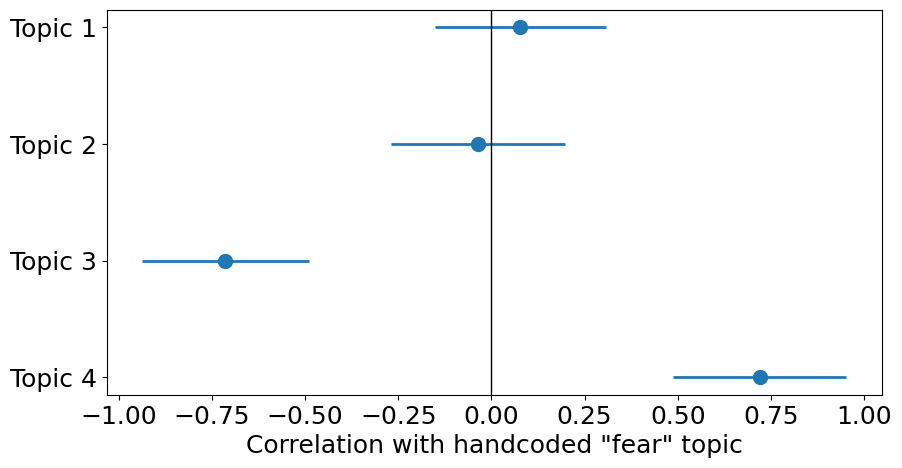

In [30]:
# Convert DataFrame to numeric data type
btm_gadarian_topic_probabilities = btm_gadarian_topic_probabilities.apply(pd.to_numeric, errors='coerce')
outcome_tocheck=pd.to_numeric(df['fear_ra1'])
# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []

# Run a linear regression for each topic dummy
for column in btm_gadarian_topic_probabilities.columns:
    if column != 'treatment':
        X = btm_gadarian_topic_probabilities[column]
        y = outcome_tocheck
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)
btm_gadarian_topic_probabilities.columns=['Topic 1','Topic 2','Topic 3','Topic 4', 'treatment']
        
# Plot coefficients with confidence intervals
# Define your desired font size and marker size
font_size = 18
marker_size = 10
line_width = 2

# Plot coefficients with confidence intervals
plt.figure(figsize=(10, 5))

topic_order=np.arange(len(coefficients),0,-1)-1
# Plot error bars with increased marker size and line width
plt.errorbar(coefficients, topic_order, 
             xerr=[abs((top-bot)/2) for top, bot in conf_intervals],
             fmt='o', markersize=marker_size, elinewidth=line_width)

plt.yticks(topic_order, 
           btm_gadarian_topic_probabilities.columns[btm_gadarian_topic_probabilities.columns != 'treatment'], fontsize=font_size)
# plt.title('BTM: regression of Topics on Fear (handcoded)')
# Increase font size for x-axis labels
plt.xticks(fontsize=font_size)
plt.xlabel('Correlation with handcoded "fear" topic', fontsize=18)  # Increase font size here

plt.axvline(0, color='black',linewidth=1)

plt.savefig(path_graphs+'btm_topic_treatment_RA1_fear_gadarian.png',bbox_inches='tight')
plt.show()

In [31]:
print('Treatment=1')
print(coeff_sentiment[coeff_sentiment['coefficient']>0]['sentiment'].mean())
print('Treatment=0')
print(coeff_sentiment[coeff_sentiment['coefficient']<0]['sentiment'].mean())

Treatment=1
-0.07628
Treatment=0
-0.09978000000000001


In [32]:
top_words_per_topic_btm

[['illegal', 'job', 'immigration', 'immigrant', 'people'],
 ['illegal', 'pay', 'immigrant', 'people', 'job'],
 ['people', 'country', 'think', 'come', 'worry'],
 ['immigrant', 'citizen', 'country', 'people', 'pay']]

In [33]:
# Flatten the list of lists into a single list
all_words_per_topic_btm = [word for sublist in top_words_per_topic_btm for word in sublist]

# Remove duplicates by converting the list to a set
unique_words = set(all_words_per_topic_btm)

# If you need a list, convert the set back to a list
all_words_per_topic_btm = list(unique_words)

In [34]:
# overall quality score for all four BTM topics
cosine_matrix_btm=CTApy.create_cosine_matrix(pretrained_model, all_words_per_topic_btm)
CTApy.calculate_quality_all(top_words_per_topic_btm, cosine_matrix_btm)

0.19818649264790386

In [35]:
# STM

In [36]:
stm_gadarian_topic_probabilities=pd.read_csv(
    path_data+"stm_gadarian_topic_probabilities.csv"
,sep=",",dtype=str)

stm_words=pd.read_csv(path_data+"stm_gadarian_top_words.csv",
                      sep=",",dtype=str)

In [37]:
stm_gadarian_ra_topics=stm_gadarian_topic_probabilities[['fear_ra1','fear_ra2']]

In [38]:
stm_gadarian_topic_probabilities=stm_gadarian_topic_probabilities.drop(columns=['fear_ra1','fear_ra2'])

[['people', 'country', 'pay', 'citizen', 'english'], ['immigrant', 'immigration', 'border', 'work', 'security'], ['illegal', 'legal', 'worry', 'welfare', 'crime'], ['job', 'come', 'think', 'need', 'americans']]
Average compound score for sublist 1: -0.02054
Average compound score for sublist 2: 0.068
Average compound score for sublist 3: -0.28242
Average compound score for sublist 4: 0.0


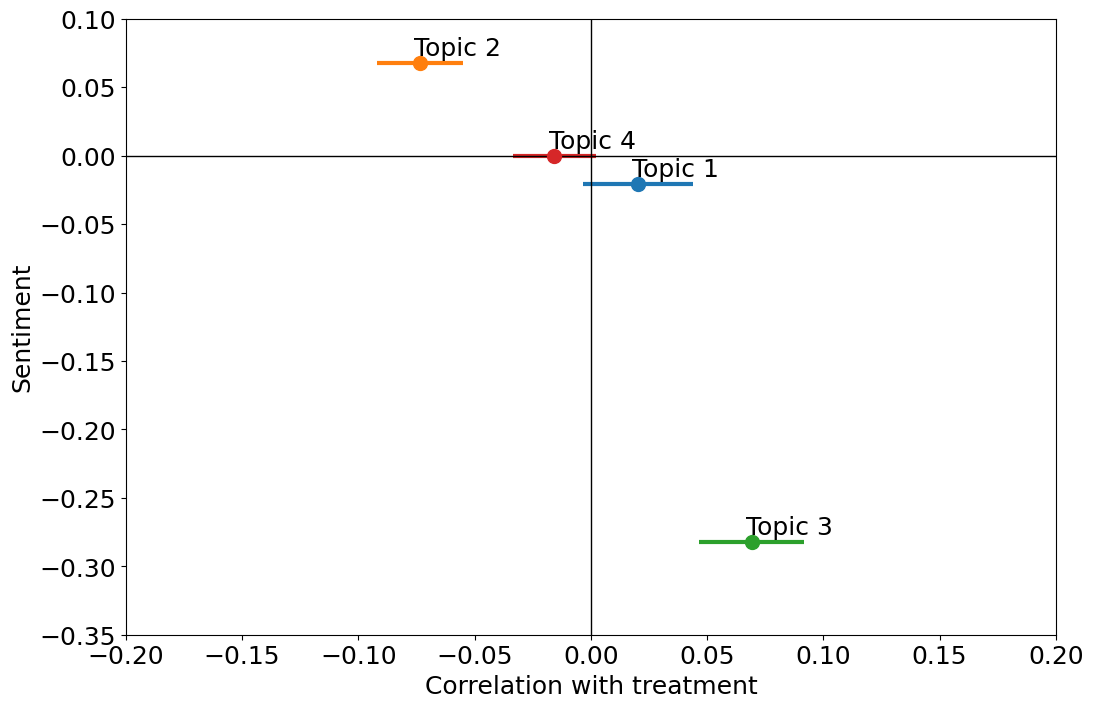

In [39]:
# Convert DataFrame to numeric data type
stm_gadarian_topic_probabilities = stm_gadarian_topic_probabilities.apply(pd.to_numeric, errors='coerce')

# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []

# Run a linear regression for each topic dummy
for column in stm_gadarian_topic_probabilities.columns:
    if column != 'outcome':
#         X = stm_gadarian_topic_probabilities[column]
#         y = stm_gadarian_topic_probabilities['treatment']
        X = stm_gadarian_topic_probabilities['outcome']
        y = stm_gadarian_topic_probabilities[column]
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)


top_words_per_topic_stm = [words[0] for words in [stm_words[col].str.split(', ').tolist() for col in stm_words.columns]]
print(top_words_per_topic_stm)
# Initialize an empty list to hold the average compound scores
average_scores = []

# Loop over the sublists
for sublist in top_words_per_topic_stm:
    # Initialize a variable to hold the sum of the compound scores
    compound_sum = 0
    # Loop over the words in the sublist
    for word in sublist:
        # Get the sentiment scores
        sentiment = analyzer.polarity_scores(word)
        # Add the compound score to the sum
        compound_sum += sentiment['compound']
    # Calculate the average compound score and add it to the list of average scores
    average_scores.append(compound_sum / len(sublist))

# Print the average compound scores
for i, score in enumerate(average_scores):
    print(f"Average compound score for sublist {i + 1}: {score}")
    
coeff_sentiment=pd.DataFrame({'topic':stm_gadarian_topic_probabilities.columns[stm_gadarian_topic_probabilities.columns != 'outcome'],
                              'coefficient':coefficients,'sentiment':average_scores, 'conf_intervals':conf_intervals})   
# Create scatterplot

plt.figure(figsize=(12, 8))  # Increase plot size

# Add error bars
for i in range(coeff_sentiment.shape[0]):
    x = coeff_sentiment['coefficient'][i]
    y = coeff_sentiment['sentiment'][i]
    ci = coeff_sentiment['conf_intervals'][i]
    plt.errorbar(x, y, xerr=np.array([[x - ci[0]], [ci[1] - x]]), 
                 fmt='o', markersize=10, linewidth=3)  # Increase markersize and linewidth here

coeff_sentiment['topic']=['Topic 1','Topic 2','Topic 3','Topic 4'] 

# Add labels
offset_y = 0.0055
offset_x = 0.0025 # Adjust this value to move the labels up or down
for i in range(coeff_sentiment.shape[0]):
    plt.text(coeff_sentiment['coefficient'][i] - offset_x, 
             coeff_sentiment['sentiment'][i] + offset_y, coeff_sentiment['topic'][i], fontsize=18)  # Increase font size here

plt.axhline(0, color='black',linewidth=1)  # Add y-axis line at 0
plt.axvline(0, color='black',linewidth=1)  # Add x-axis line at 0

# Define axis limits
plt.xlim([-0.2, 0.2])  # Set x-axis limits
plt.ylim([-0.35, 0.1])  # Set y-axis limits

plt.xlabel('Correlation with treatment', fontsize=18)  # Increase font size here
plt.ylabel('Sentiment', fontsize=18)  # Increase font size here
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig(path_graphs+'stm_topic_treatment_gadarian.png',bbox_inches='tight')
plt.show()

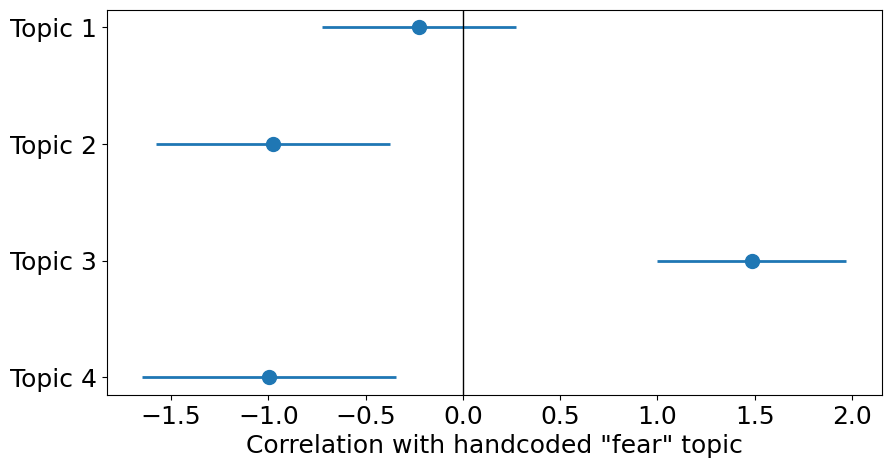

In [40]:
# Convert DataFrame to numeric data type
stm_gadarian_topic_probabilities.columns=['Topic 1','Topic 2','Topic 3','Topic 4', 'treatment']
df_final = stm_gadarian_topic_probabilities.apply(pd.to_numeric, errors='coerce')
outcome_tocheck=pd.to_numeric(stm_gadarian_ra_topics['fear_ra1'])
# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []

# Run a linear regression for each topic dummy
for column in df_final.columns:
    if column != 'treatment':
        X = df_final[column]
        y = outcome_tocheck
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)

# Plot coefficients with confidence intervals
# Define your desired font size and marker size
font_size = 18
marker_size = 10
line_width = 2

# Plot coefficients with confidence intervals
plt.figure(figsize=(10, 5))

topic_order=np.arange(len(coefficients),0,-1)-1
# Plot error bars with increased marker size and line width
plt.errorbar(coefficients, topic_order, 
             xerr=[abs((top-bot)/2) for top, bot in conf_intervals],
             fmt='o', markersize=marker_size, elinewidth=line_width)

plt.yticks(topic_order, df_final.columns[df_final.columns != 'treatment'], fontsize=font_size)
# plt.title('STM: regression of Topics on Fear (handcoded)')
# Increase font size for x-axis labels
plt.xticks(fontsize=font_size)
plt.xlabel('Correlation with handcoded "fear" topic', fontsize=18)  # Increase font size here

plt.axvline(0, color='black',linewidth=1)

plt.savefig(path_graphs+'stm_topic_treatment_RA1_fear_gadarian.png',bbox_inches='tight')
plt.show()

In [41]:
print('Treatment=1')
print(coeff_sentiment[coeff_sentiment['coefficient']>0]['sentiment'].mean())
print('Treatment=0')
print(coeff_sentiment[coeff_sentiment['coefficient']<0]['sentiment'].mean())

Treatment=1
-0.15148
Treatment=0
0.034


In [42]:
# Flatten the list of lists into a single list
all_words_per_topic_stm = [word for sublist in top_words_per_topic_stm for word in sublist]

# Remove duplicates by converting the list to a set
unique_words = set(all_words_per_topic_stm)

# If you need a list, convert the set back to a list
all_words_per_topic_stm = list(unique_words)

In [43]:
# Overall quality score for all four STM topics
cosine_matrix_stm=CTApy.create_cosine_matrix(pretrained_model, all_words_per_topic_stm)
CTApy.calculate_quality_all(top_words_per_topic_stm, cosine_matrix_stm)

0.20089103719009974

In [44]:
# LDA


In [45]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import string

# Assuming 'text' column contains the text data
documents = text_lemma.tolist()

texts = []
for document in documents:
    # Remove punctuation
    text = "".join([char for char in document if char not in string.punctuation])
    # Tokenize and lowercase
    words = text.lower().split()
    texts.append(words)

# Creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(texts)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(text) for text in texts]



In [46]:
# Creating the object for LDA model using gensim library
random.seed(42)
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix
ldamodel = Lda(doc_term_matrix, num_topics=4, id2word = dictionary, passes=50, random_state=42)



In [47]:
# Print the topics
topics = ldamodel.print_topics(num_topics=4, num_words=5)

# Create a list of lists for the top words in each topic
lda_top_words_per_topic = []
for topic in topics:
    words = topic[1].split("+")
    words = [word.split("*")[1].strip().strip('"') for word in words]
    lda_top_words_per_topic.append(words)

print(lda_top_words_per_topic)

[['illegal', 'pay', 'job', 'think', 'people'], ['people', 'immigrant', 'country', 'illegal', 'come'], ['immigration', 'illegal', 'people', 'think', 'job'], ['come', 'illegal', 'worry', 'immigrant', 'immigration']]


In [48]:
# Flatten the list of lists into a single list
lda_top_words_per_topic_flat = [word for sublist in lda_top_words_per_topic for word in sublist]

# Remove duplicates by converting the list to a set
unique_words = set(lda_top_words_per_topic_flat)

# If you need a list, convert the set back to a list
lda_top_words_per_topic_flat = list(unique_words)

In [49]:
cosine_matrix=CTApy.create_cosine_matrix(pretrained_model, lda_top_words_per_topic_flat)
CTApy.calculate_quality_all(lda_top_words_per_topic, cosine_matrix)

0.1622637574345945

In [50]:
# Get the topic probabilities for each document
doc_topics = [ldamodel.get_document_topics(doc) for doc in doc_term_matrix]

# Initialize a dataframe
topics_lda = pd.DataFrame()

# For each topic, create a column in the dataframe
for i in range(ldamodel.num_topics):
    topics_lda['topic_' + str(i)] = pd.to_numeric([doc[i][1] if i < len(doc) else 0 for doc in doc_topics])
topics_lda['treatment']=pd.to_numeric(outcome).reset_index(drop=True)

Average compound score for sublist 1: -0.13202
Average compound score for sublist 2: -0.11148
Average compound score for sublist 3: -0.11148
Average compound score for sublist 4: -0.19956000000000002


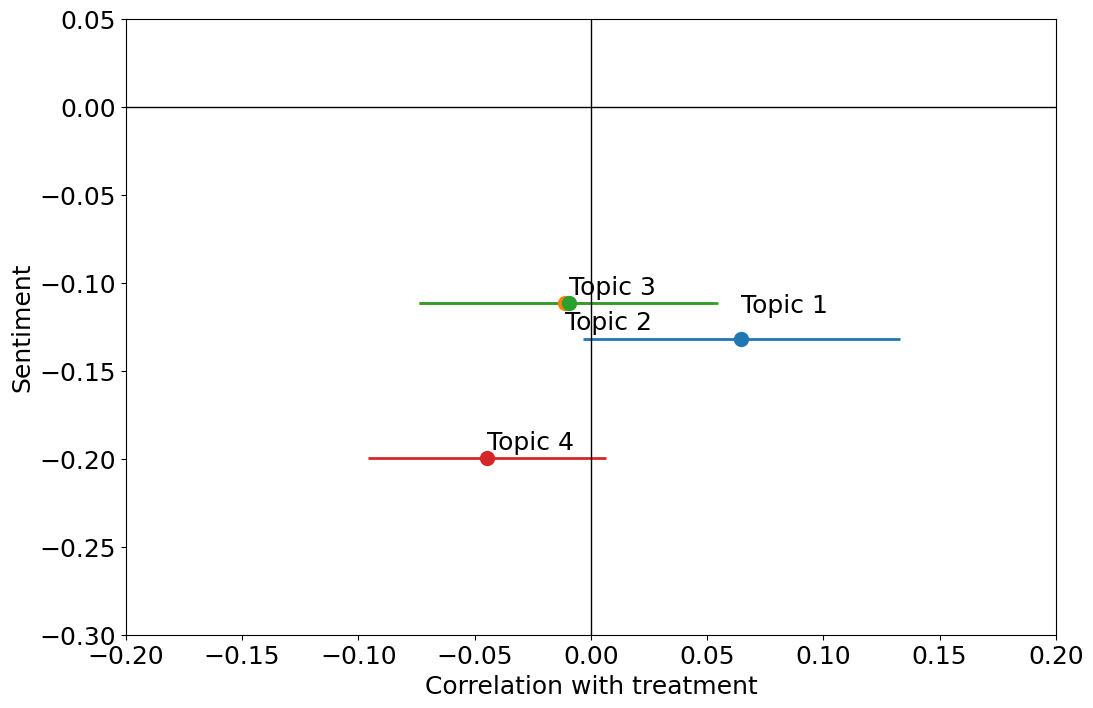

In [51]:
# Initialize an empty list to hold the average compound scores
average_scores = []

# Loop over the sublists
for sublist in lda_top_words_per_topic:
    # Initialize a variable to hold the sum of the compound scores
    compound_sum = 0
    # Loop over the words in the sublist
    for word in sublist:
        # Get the sentiment scores
        sentiment = analyzer.polarity_scores(word)
        # Add the compound score to the sum
        compound_sum += sentiment['compound']
    # Calculate the average compound score and add it to the list of average scores
    average_scores.append(compound_sum / len(sublist))

# Print the average compound scores
for i, score in enumerate(average_scores):
    print(f"Average compound score for sublist {i + 1}: {score}")



# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []

# Run a linear regression for each topic dummy
for column in topics_lda.columns:
    if column != 'treatment':
        X = topics_lda['treatment']
        y = topics_lda[column]
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)


coeff_sentiment=pd.DataFrame({'topic':topics_lda.columns[topics_lda.columns != 'treatment'],
                              'coefficient':coefficients,'sentiment':average_scores, 'conf_intervals':conf_intervals})   
# Define your desired font size, marker size, and line width
font_size = 18
marker_size = 10
line_width = 2

# Create scatterplot
plt.figure(figsize=(12, 8))  # Increase plot size

# Add error bars
for i in range(coeff_sentiment.shape[0]):
    x = coeff_sentiment['coefficient'][i]
    y = coeff_sentiment['sentiment'][i]
    ci = coeff_sentiment['conf_intervals'][i]
    plt.errorbar(x, y, xerr=np.array([[x - ci[0]], [ci[1] - x]]), 
                 fmt='o', markersize=marker_size, linewidth=line_width)  # Increase markersize and linewidth here
    
coeff_sentiment['topic']=['Topic 1','Topic 2','Topic 3','Topic 4'] 
# Add labels with manual adjustments for specific labels
for i in range(coeff_sentiment.shape[0]):
    offset = 0.005  # Default offset
    if coeff_sentiment['topic'][i] == 'Topic 1':  # Replace 'topic1' with the actual topic label
        offset = 0.015  # Increase offset for 'topic1'
    elif coeff_sentiment['topic'][i] == 'Topic 2':  # Replace 'topic2' with the actual topic label
        offset = -0.015  # Decrease offset for 'topic2'
    plt.text(coeff_sentiment['coefficient'][i], 
             coeff_sentiment['sentiment'][i] + offset, coeff_sentiment['topic'][i], fontsize=font_size)  # Increase font size here

plt.axhline(0, color='black',linewidth=1)  # Add y-axis line at 0
plt.axvline(0, color='black',linewidth=1)  # Add x-axis line at 0

# Define axis limits
plt.xlim([-0.2, 0.2])  # Set x-axis limits
plt.ylim([-0.3, 0.05])  # Set y-axis limits

plt.xlabel('Correlation with treatment', fontsize=18)  # Increase font size here
plt.ylabel('Sentiment', fontsize=font_size)  # Increase font size here
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.savefig(path_graphs+'lda_topic_treatment_gadarian.png',bbox_inches='tight')
plt.show()




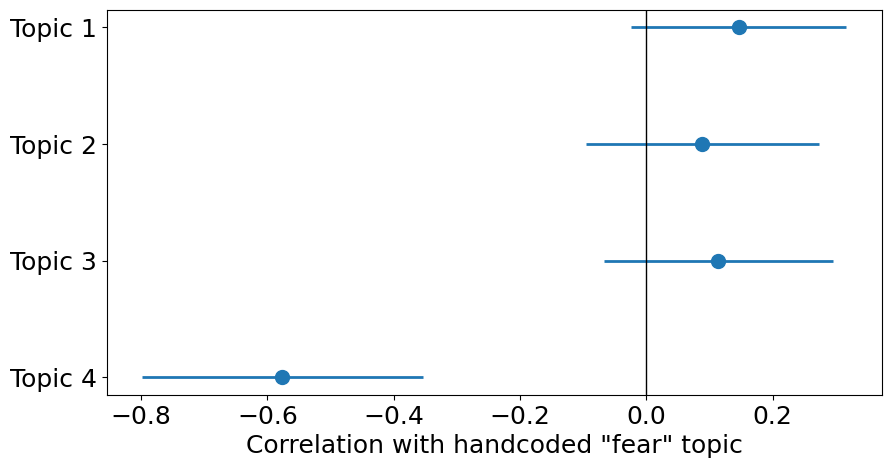

In [54]:
# Convert DataFrame to numeric data type
topics_lda = topics_lda.apply(pd.to_numeric, errors='coerce')
topics_lda.columns=['Topic 1','Topic 2','Topic 3','Topic 4', 'outcome']
outcome_tocheck=pd.to_numeric(df['fear_ra1'])
# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []

# Run a linear regression for each topic dummy
for column in topics_lda.columns:
    if column != 'outcome':
        X = topics_lda[column]
        y = outcome_tocheck
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)

# Plot coefficients with confidence intervals
# Define your desired font size and marker size
font_size = 18
marker_size = 10
line_width = 2

# Plot coefficients with confidence intervals
plt.figure(figsize=(10, 5))


topic_order=np.arange(len(coefficients),0,-1)-1

# Plot error bars with increased marker size and line width
plt.errorbar(coefficients, topic_order, 
             xerr=[abs((top-bot)/2) for top, bot in conf_intervals],
             fmt='o', markersize=marker_size, elinewidth=line_width)

plt.yticks(topic_order, topics_lda.columns[topics_lda.columns != 'outcome'], fontsize=font_size)
# plt.title('LDA: regression of Topics on Fear (handcoded)')
# Increase font size for x-axis labels
plt.xticks(fontsize=font_size)
plt.xlabel('Correlation with handcoded "fear" topic', fontsize=18)  # Increase font size here

plt.axvline(0, color='black',linewidth=1)

plt.savefig(path_graphs+'lda_topic_treatment_RA1_fear_gadarian.png',bbox_inches='tight')
plt.show()

In [55]:
np.mean([abs(coef) for coef in coefficients])

0.23123916800558003

In [56]:
print('Treatment=1')
print(coeff_sentiment[coeff_sentiment['coefficient']>0]['sentiment'].mean())
print('Treatment=0')
print(coeff_sentiment[coeff_sentiment['coefficient']<0]['sentiment'].mean())

Treatment=1
-0.13202
Treatment=0
-0.14084
